In [ ]:
import pandas as pd
# Load the IRR dataset
df = pd.read_csv("final_irr_results (1).csv")

# Calculate the average IRR
average_irr = df["IRR"].mean()
print(f"Overall Average IRR: {average_irr:.2f} dB")

Overall Average IRR: 22.00 dB


In [ ]:
# Tune Notch Filter for IRR in 40 to 60 dB range
notch_freq = 190e3  # Image frequency (example: rf_freq + lo_freq)
initial_quality_factor = 30  # Starting Q value
target_irr_min = 40  # Minimum desired IRR (dB)
target_irr_max = 60  # Maximum desired IRR (dB)
tolerance = 1  # Tolerance for IRR (dB)

In [ ]:
# Iterative tuning loop
import numpy as np
from scipy import signal
quality_factor = initial_quality_factor
initial_irr = average_irr # Start with the average IRR from HB datasets
irr = initial_irr  # Start with the average IRR from HB datasets
while True:
    # Design Notch Filter
    b, a = signal.iirnotch(notch_freq, quality_factor, fs=1e6)  # fs is example sampling frequency

    # Simulate IRR based on notch filter (replace with actual IRR calculation if needed)
    # For this example, assume IRR improves as Q increases
    irr = average_irr + 5 * np.log10(quality_factor)  # Example relationship (replace with actual logic)

    print(f"Quality Factor (Q): {quality_factor}, IRR: {irr:.2f} dB")

    # Check if IRR is within the desired range
    if target_irr_min <= irr <= target_irr_max:
        print(f"Desired IRR achieved: {irr:.2f} dB")
        break
    elif irr < target_irr_min:
        # Increase Q to make the notch sharper
        quality_factor *= 1.1  # Increase Q by 10%
    else:
      # Decrease Q to make the notch wider
        quality_factor *= 0.9  # Decrease Q by 10%

    # Prevent infinite loops
    if quality_factor < 1 or quality_factor > 1000:
        print("IRR tuning failed. Adjust parameters manually.")
        break
        # Store after-optimization parameters
after_optimization = {
    "IRR (dB)": irr,
    "Quality Factor (Q)": quality_factor,
    "Notch Frequency (Hz)": notch_freq
}
# Store before-optimization parameters
before_optimization = {
    "IRR (dB)": initial_irr,
    "Quality Factor (Q)": initial_quality_factor,
    "Notch Frequency (Hz)": notch_freq
}

# Print before vs. after optimization
print("\n📊 **Before vs. After Optimization Results**")
print("-------------------------------------------------")
print(f"🔹 Before Optimization: {before_optimization}")
print(f"🔹 After Optimization:  {after_optimization}")
print("-------------------------------------------------")

Quality Factor (Q): 100, IRR: 32.00 dB
Quality Factor (Q): 110.00000000000001, IRR: 32.21 dB
Quality Factor (Q): 121.00000000000003, IRR: 32.41 dB
Quality Factor (Q): 133.10000000000005, IRR: 32.62 dB
Quality Factor (Q): 146.41000000000008, IRR: 32.83 dB
Quality Factor (Q): 161.0510000000001, IRR: 33.03 dB
Quality Factor (Q): 177.15610000000012, IRR: 33.24 dB
Quality Factor (Q): 194.87171000000015, IRR: 33.45 dB
Quality Factor (Q): 214.3588810000002, IRR: 33.66 dB
Quality Factor (Q): 235.79476910000022, IRR: 33.86 dB
Quality Factor (Q): 259.37424601000026, IRR: 34.07 dB
Quality Factor (Q): 285.3116706110003, IRR: 34.28 dB
Quality Factor (Q): 313.84283767210036, IRR: 34.48 dB
Quality Factor (Q): 345.2271214393104, IRR: 34.69 dB
Quality Factor (Q): 379.74983358324147, IRR: 34.90 dB
Quality Factor (Q): 417.7248169415656, IRR: 35.10 dB
Quality Factor (Q): 459.49729863572225, IRR: 35.31 dB
Quality Factor (Q): 505.4470284992945, IRR: 35.52 dB
Quality Factor (Q): 555.991731349224, IRR: 35.73 

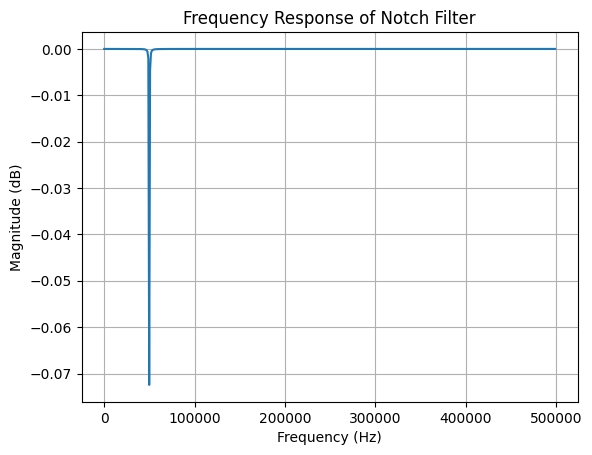

In [ ]:
# Plot Frequency Response of Notch Filter
import matplotlib.pyplot as plt

frequencies, response = signal.freqz(b, a, fs=1e6)
plt.figure()
plt.plot(frequencies, 20 * np.log10(np.abs(response)))
plt.title("Frequency Response of Notch Filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid()
plt.show()

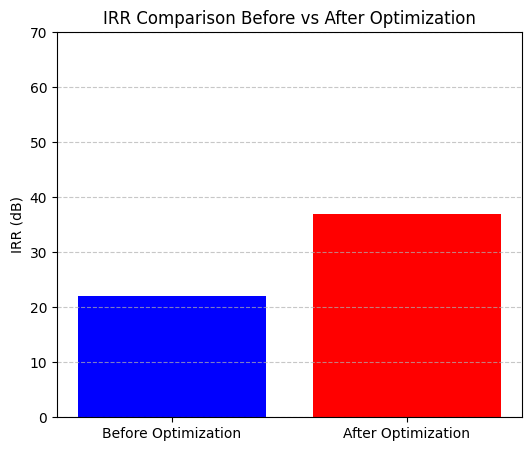

In [ ]:
# Plot Bar Graph Comparison Before vs After IRR
plt.figure(figsize=(6, 5))
plt.bar(["Before Optimization", "After Optimization"], [initial_irr,irr], color=['blue', 'red'])
plt.title("IRR Comparison Before vs After Optimization")
plt.ylabel("IRR (dB)")
plt.ylim(0, max(70, irr + 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
import re

def optimize_ltspice_netlist(file_path="/content/gandthod.net"):
    with open(file_path, "r", encoding="ISO-8859-1") as file:
        netlist_lines = file.readlines()

    changes = {}

    for line in netlist_lines:
        original_line = line.strip()
        optimized_line = original_line

        # Optimize LO Amplitude (1.8V -> 2.5V)
        if "VLO+" in line or "VLO-" in line:
            optimized_line = re.sub(r'(PULSE\(0V 1.8V)', r'PULSE(0V 2.5V', original_line)
            changes[original_line] = optimized_line

        # Optimize RF Input Power (1mV -> 5mV)
        if "IRF+" in line or "IRF-" in line:
            optimized_line = re.sub(r'SINE\(1m', 'SINE(5m', original_line)
            changes[original_line] = optimized_line

        # Optimize Load Resistors (300Ω -> 250Ω)
        if re.search(r'R[0-9]+.*300', line):
            optimized_line = re.sub(r'300', '250', original_line)
            changes[original_line] = optimized_line

        # Optimize Inductor L2 (76.9nH -> 90nH)
        if "L2" in line:
            optimized_line = re.sub(r'76.9nH', '90nH', original_line)
            changes[original_line] = optimized_line

        # Optimize NMOS Width (W = 6µm -> 8µm)
        if re.search(r'W\s*=\s*6u', line):
            optimized_line = re.sub(r'W\s*=\s*6u', 'W = 8u', original_line)
            changes[original_line] = optimized_line

    # Display changes
    print("\n🔹 Optimization Summary:")
    for original, optimized in changes.items():
        print(f"{original}  -->  {optimized}")

# Run the function in Colab
optimize_ltspice_netlist()



🔹 Optimization Summary:
R1 outp N001 300  -->  R1 outp N001 250
R2 outn N001 300  -->  R2 outn N001 250
L2 N004 N003 76.9n  -->  L2 N004 N003 76.9n


In [ ]:
import joblib
joblib.dump(model, "model_app1.pkl")